Using a dataset of your choice, select an outcome variable and then pick four or five other variables (one to two categorical, three to four continuous) to act as the basis for features. Explore the variables using the univariate and bivariate methods you've learned so far. 

Next, based on what you learned via your data exploration, create ten new features. Explain the reasoning behind each one.

Finally, use filtering methods to select the five best features and justify your choices.

Fun with categorical variables
    0 or 1 value
    
Changing variable types
    We can also take a continuous variable and make it categorical.
    
Categorical, Ordinal, Interval, Ratio

Combining two or more highly-correlated variables

Dealing with non-normality
    Transform to normal
    
Creating linear relationships

Making variables easier to understand in light of the research question

Leveling the playing field

All about interactions

GlobalEventID
SQLDATE
AvgTone
QuadClass 
Goldstein Scale - 
NumMentions (normalize by overall mentions going on) - Ratio
IsRootEvent - Categorical
EventBaseCode
Actor1Geo_ADM1Code/Actor2Geo_ADM1Code/ActionGeo_ADM1Code

SOURCEURL and Tone

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.preprocessing import StandardScaler
%matplotlib inline

from GDELT_utils import GDELT_columns, usecols, dtype_dict, \
                        cameo_dict, map_cameo_to_text, \
                        state_dict, mem_usage, state_heat_map
        
data_2008 = "./200811.csv"
data_2016 = "./20161108.export.CSV"

In [2]:
interest = ["GLOBALEVENTID", "SQLDATE",
            "AvgTone", "QuadClass", "GoldsteinScale",
            "NumMentions", "IsRootEvent", "EventRootCode",
            #"EventBaseCode", "EventCode",
            #"Actor1Code", "Actor2Code",
            "Actor1CountryCode", "Actor2CountryCode",
            "Actor1KnownGroupCode", "Actor2KnownGroupCode",
            #"Actor1EthnicCode", "Actor2EthnicCode",
            "Actor1Religion1Code", "Actor2Religion1Code",
            #"Actor1Religion2Code", "Actor2Religion2Code",
            "Actor1Type1Code", "Actor2Type1Code",
            #"Actor1Type2Code", "Actor2Type2Code",
            #"Actor1Type3Code", "Actor2Type3Code",
            "Actor1Geo_CountryCode", "Actor2Geo_CountryCode", "ActionGeo_CountryCode",
            #"Actor1Geo_ADM1Code", "Actor2Geo_ADM1Code", "ActionGeo_ADM1Code"
           ]

# Unknown country versus definitely not this one
# I.e. we might not know a country at all
# should this be different for a model than knowing it's not all of these

# A record that contains a missing country, will have all 0 in the vector (that is your suggestion 1)
# Replace NA with "UKNOWN" and treat it as another country; this will make your record all zeros except 1 for is_UNKNOWN feature (your suggestion 2)
# Choose top K (maybe 10) largest countries, and put everything else in the K+1 bucket. That is almost like a manual dimensionality reduction.

In [3]:
import os

In [63]:
active_df = pd.read_csv('D:/GDELT-files/events/1979.zip', sep='\t', names=GDELT_columns[:57], 
                            compression='zip',
                            usecols=interest, dtype=dtype_dict, 
                            parse_dates=['SQLDATE'])
print(mem_usage(active_df))
print(active_df.columns)
print(active_df.info(memory_usage='deep'))
write_path = "D:/GDELT-files-trim/" + 'D:/GDELT-files/events/1979.zip'.split('/')[-1].replace('zip', 'pkl')
print(write_path)
active_df.to_pickle(write_path #sep='\t', 
                    #index=False, encoding='utf-8'
                   )
active_df_2 = pd.read_pickle('D:/GDELT-files-trim/1979.pkl'
                          #compression='zip',
                          #sep='\t', 
                             #usecols=interest, 
                             #dtype=dtype_dict, 
                          #parse_dates=['SQLDATE']
                            )
print(mem_usage(active_df_2))
print(active_df_2.info(memory_usage='deep'))

print(active_df.equals(active_df_2))

(18.64026165008545, '18.64 MB')
Index(['GLOBALEVENTID', 'SQLDATE', 'Actor1CountryCode', 'Actor1KnownGroupCode',
       'Actor1EthnicCode', 'Actor1Religion1Code', 'Actor1Religion2Code',
       'Actor1Type1Code', 'Actor2CountryCode', 'Actor2KnownGroupCode',
       'Actor2EthnicCode', 'Actor2Religion1Code', 'Actor2Religion2Code',
       'Actor2Type1Code', 'IsRootEvent', 'EventRootCode', 'QuadClass',
       'GoldsteinScale', 'NumMentions', 'AvgTone', 'Actor1Geo_CountryCode',
       'Actor2Geo_CountryCode', 'ActionGeo_CountryCode'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 430941 entries, 0 to 430940
Data columns (total 23 columns):
GLOBALEVENTID            430941 non-null uint32
SQLDATE                  430941 non-null datetime64[ns]
Actor1CountryCode        282196 non-null category
Actor1KnownGroupCode     4647 non-null category
Actor1EthnicCode         1658 non-null category
Actor1Religion1Code      5393 non-null category
Actor1Religion2Code      2031 non-n

In [9]:
df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
df_2016 = pd.read_csv(data_2016, sep='\t', names=GDELT_columns, 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])

df_2008_us = df_2008.loc[(df_2008['ActionGeo_CountryCode'] == 'US') |\
                         (df_2008['Actor1Geo_CountryCode'] == 'US') |\
                         (df_2008['Actor2Geo_CountryCode'] == 'US'),:].copy()
df_2016_us = df_2016.loc[(df_2016['ActionGeo_CountryCode'] == 'US') |\
                         (df_2016['Actor1Geo_CountryCode'] == 'US') |\
                         (df_2016['Actor2Geo_CountryCode'] == 'US'),:].copy()

election_day_2008 = np.datetime64('2008-11-04')
df_2008_usel = df_2008_us.loc[df_2008_us['SQLDATE'] == election_day_2008,:] \
                         .copy()
    
election_day_2016 = np.datetime64('2016-11-08')
df_2016_usel = df_2016_us.loc[df_2016_us['SQLDATE'] == election_day_2016,:] \
                         .copy()

In [17]:
df_2016['Actor1Geo_CountryCode'].value_counts().sum()

206630

In [6]:
df_2016['Actor1Type2Code'].value_counts().sum()

6957

In [7]:
df_2016['Actor1Type3Code'].value_counts().sum()

220

In [4]:
dfs = [df_2008_usel, df_2016_usel]

In [5]:
def plot_both_dfs(plot, x, y):
    fig,axes = plt.subplots(1, 2, figsize=(10,6), sharex=True, sharey=True)
    for ax, df in zip(axes, dfs):
        plot(x=x, y=y, data=df, ax=ax)

In [6]:
df_2008.columns

Index(['GLOBALEVENTID', 'SQLDATE', 'Actor1CountryCode', 'Actor1Religion1Code',
       'Actor1Type1Code', 'Actor2CountryCode', 'Actor2Religion1Code',
       'Actor2Type2Code', 'IsRootEvent', 'EventCode', 'EventBaseCode',
       'QuadClass', 'GoldsteinScale', 'NumMentions', 'AvgTone',
       'Actor1Geo_CountryCode', 'Actor1Geo_ADM1Code', 'Actor2Geo_CountryCode',
       'Actor2Geo_ADM1Code', 'ActionGeo_CountryCode', 'ActionGeo_ADM1Code'],
      dtype='object')

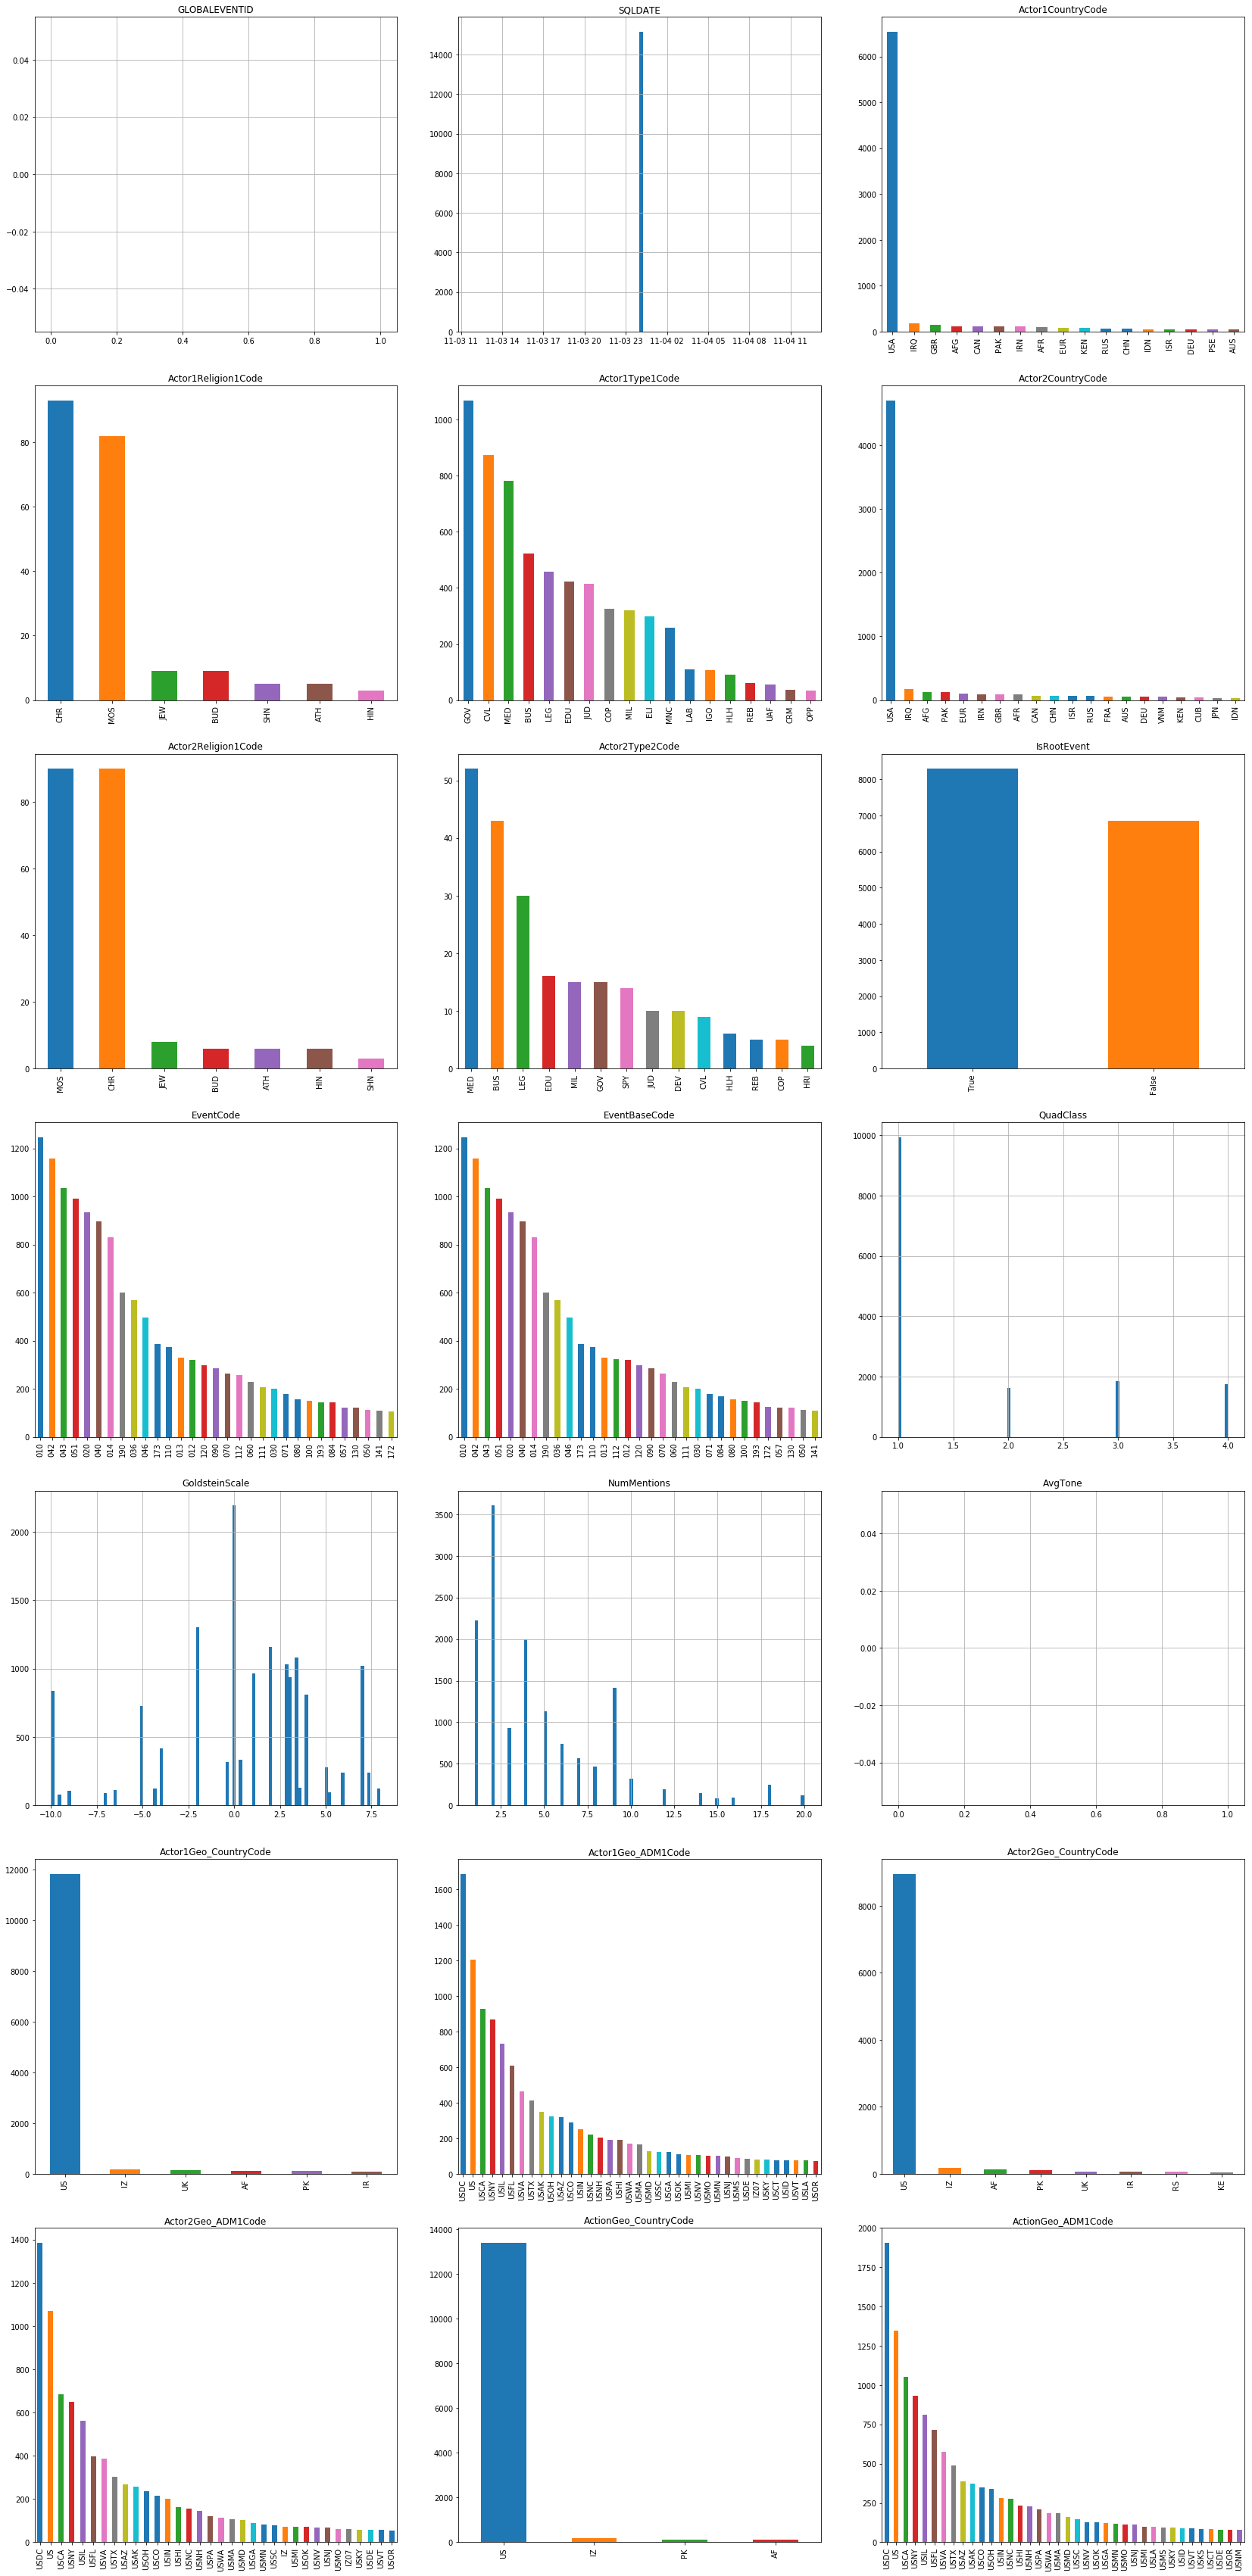

In [7]:
# https://stackoverflow.com/questions/39646070/pandas-histogram-plot-histogram-for-each-column-as-subplot-of-a-big-figure
fig, axes = plt.subplots(len(df_2008.columns)//3, 3, figsize=(24, 48))
plt.tight_layout(pad=5, w_pad=5, h_pad=5)
for col, axis in zip(df_2008_usel.columns, axes.flatten()):
    no_na = df_2008_usel[col].dropna().copy()
    enough_data = no_na.value_counts() \
                    [(no_na.value_counts()/ \
                        no_na.value_counts().sum()) > 0.005]
    df_2008_graph = df_2008_usel[col][df_2008[col].isin(enough_data.index)]
    dtype_name = df_2008_graph.dtype.name
    axis.set_title(col)
    if dtype_name == 'category' or dtype_name == 'bool' \
            or dtype_name == 'object':
        if dtype_name == 'category':
            df_2008_graph.cat.remove_unused_categories() \
                        .value_counts().plot(kind="bar", ax=axis)
        else:
            df_2008_graph.value_counts().plot(kind="bar", ax=axis)
    else:
        df_2008_graph.hist(bins = 100, ax=axis)

Keep differentiation for like the 10 in a category and then collapse all others in to "Other".

In [8]:
grouped_df = df_2008_usel[["EventCode", "GoldsteinScale"]].groupby("EventCode")

for key, item in grouped_df:
    print(grouped_df.get_group(key).iloc[0], "\n\n")
    
event_code_to_goldstein = {}
for event_code, desc in cameo_dict.items():
    print(event_code)

EventCode         010
GoldsteinScale      0
Name: 112290, dtype: object 


EventCode         011
GoldsteinScale   -0.1
Name: 122377, dtype: object 


EventCode         012
GoldsteinScale   -0.4
Name: 112441, dtype: object 


EventCode         013
GoldsteinScale    0.4
Name: 111816, dtype: object 


EventCode         014
GoldsteinScale      0
Name: 112443, dtype: object 


EventCode         015
GoldsteinScale      0
Name: 113736, dtype: object 


EventCode         016
GoldsteinScale     -2
Name: 116228, dtype: object 


EventCode         017
GoldsteinScale      0
Name: 116623, dtype: object 


EventCode         018
GoldsteinScale    3.4
Name: 118628, dtype: object 


EventCode         020
GoldsteinScale      3
Name: 111677, dtype: object 


EventCode         021
GoldsteinScale    3.4
Name: 150569, dtype: object 


EventCode         0214
GoldsteinScale     3.4
Name: 122411, dtype: object 


EventCode         022
GoldsteinScale    3.2
Name: 113751, dtype: object 


EventCode         023
G

In [9]:
df_2008_usel.corr()

,GLOBALEVENTID,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,AvgTone
GLOBALEVENTID,1.000000,-0.005042,-0.019396,-0.011767,-0.022970,0.090607
IsRootEvent,-0.005042,1.000000,-0.028825,-0.004358,0.059921,0.004720
QuadClass,-0.019396,-0.028825,1.000000,-0.743234,-0.026657,-0.117496
GoldsteinScale,-0.011767,-0.004358,-0.743234,1.000000,0.013473,0.175848
NumMentions,-0.022970,0.059921,-0.026657,0.013473,1.000000,-0.014274
AvgTone,0.090607,0.004720,-0.117496,0.175848,-0.014274,1.000000


In [10]:
df_2016_usel.corr()

,GLOBALEVENTID,IsRootEvent,QuadClass,GoldsteinScale,NumMentions,AvgTone
GLOBALEVENTID,1.000000,-0.025025,-0.015881,0.010568,-0.108420,0.058619
IsRootEvent,-0.025025,1.000000,0.012173,-0.030963,0.066061,0.041858
QuadClass,-0.015881,0.012173,1.000000,-0.764740,-0.003893,-0.341244
GoldsteinScale,0.010568,-0.030963,-0.764740,1.000000,-0.006985,0.333299
NumMentions,-0.108420,0.066061,-0.003893,-0.006985,1.000000,-0.017861
AvgTone,0.058619,0.041858,-0.341244,0.333299,-0.017861,1.000000


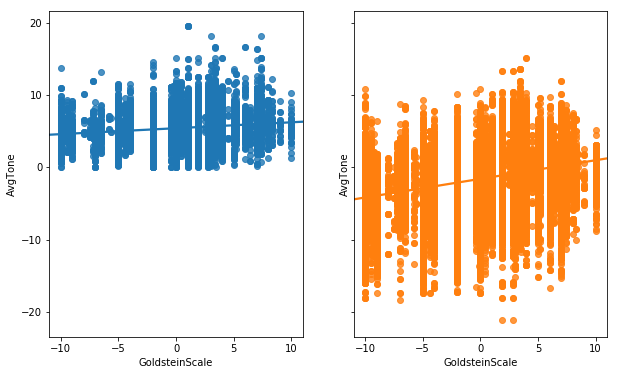

In [11]:
plot_both_dfs(sns.regplot, x="GoldsteinScale", y="AvgTone")

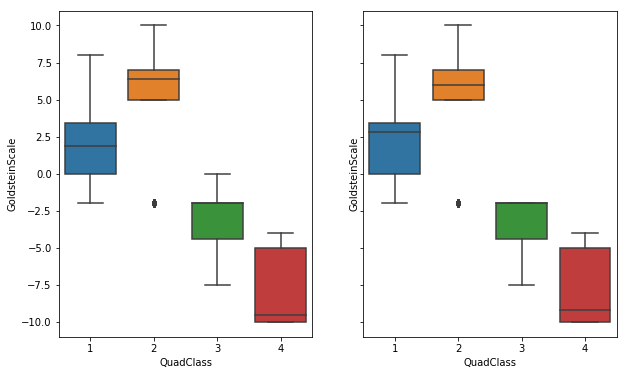

In [12]:
plot_both_dfs(sns.boxplot, x="QuadClass", y="GoldsteinScale")

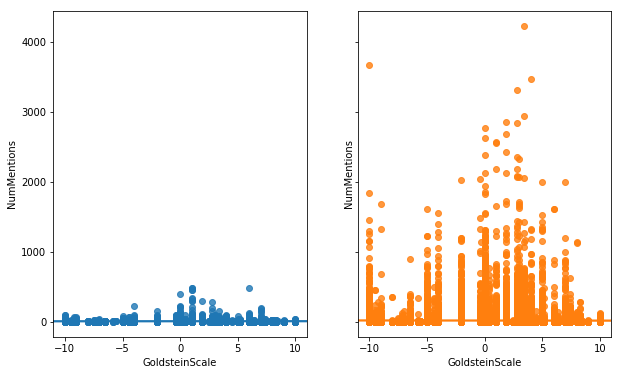

In [13]:
plot_both_dfs(sns.regplot, "GoldsteinScale", "NumMentions")

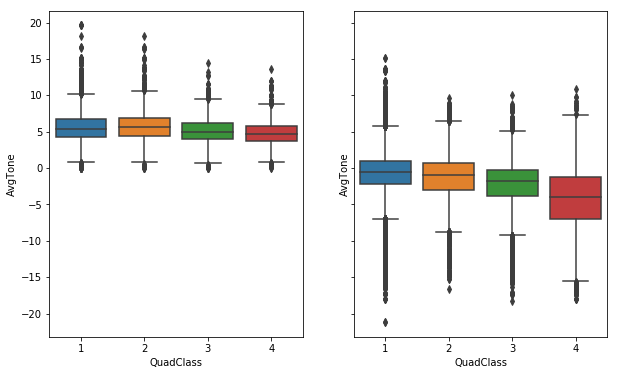

In [14]:
plot_both_dfs(sns.boxplot, "QuadClass", "AvgTone")

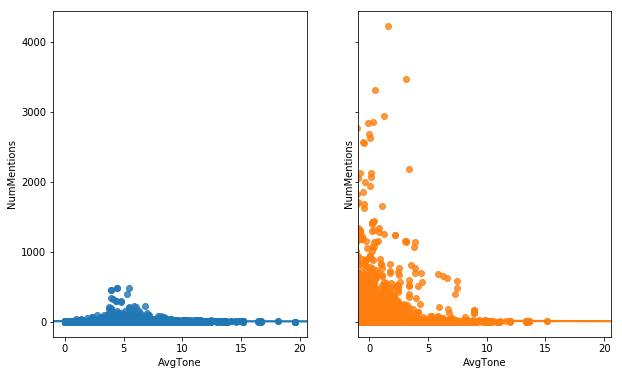

In [15]:
plot_both_dfs(sns.regplot, "AvgTone", "NumMentions")

In [ ]:
# QuadClass -> Not Conflict (1, 2) or Conflict (3, 4)
# QuadClass -> Not Violence (1, 2, 3) or Violence (4)
# TomorrowQuadClass -> Shift quad class back a day
# NormNumMentions -> normalized for the day
# NormNumMentions -> normalized by rolling average
# NormNumMentions -> normalized by the year
# GoldsteinScale + NumMentions
# GoldsteinScale + AvgTone
# AvgTone + NumMentions
# IsRootEvent + NumMentions -> Weighted Importance

# try to predict without cameo code

# split data in missing/non-missing and compare distributions of that data

# which features are generally missing record values

# GoldsteinScale is a relationship with Cameo Code and 
# Cameo Code maps 1:1 onto quadclass

# Try to predict AvgTone
# Cameo Code 

In [ ]:
from os import listdir
path_to_files = "D:/GDELT-files/events/"
GDELT_files = [path_to_files + filename for filename in listdir("D:/GDELT-files/events")]

for file_path in GDELT_files:
    try:
        active_df = pd.read_csv(file_path, sep='\t', names=GDELT_columns, 
                                compression='zip',
                                usecols=interest, dtype=dtype_dict, 
                                parse_dates=['SQLDATE'])
        write_path = "D:/GDELT-files-trim/" + file_path.split('/')[-1].replace('zip', 'pkl')
        active_df.to_pickle(write_path)
    except: 
        print("error at ", file_path)

In [5]:
import csv, sqlite3

In [4]:
con = sqlite3.connect("gdelt.db")
df_2008 = pd.read_csv(data_2008, sep='\t', names=GDELT_columns[:57], 
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
df_2008.to_sql("2008", con, if_exists='append', index=False)
con.commit()
con.close()

NameError: name 'sqlite3' is not defined

In [6]:
from os import listdir
path_to_files = "D:/GDELT-files/events/"
GDELT_files = [path_to_files + filename for filename in listdir("D:/GDELT-files/events")]

con = sqlite3.conneact("gdelt.db")

In [7]:
GDELT_files

['D:/GDELT-files/events/1979.zip',
 'D:/GDELT-files/events/1980.zip',
 'D:/GDELT-files/events/1981.zip',
 'D:/GDELT-files/events/1982.zip',
 'D:/GDELT-files/events/1983.zip',
 'D:/GDELT-files/events/1984.zip',
 'D:/GDELT-files/events/1985.zip',
 'D:/GDELT-files/events/1986.zip',
 'D:/GDELT-files/events/1987.zip',
 'D:/GDELT-files/events/1988.zip',
 'D:/GDELT-files/events/1989.zip',
 'D:/GDELT-files/events/1990.zip',
 'D:/GDELT-files/events/1991.zip',
 'D:/GDELT-files/events/1992.zip',
 'D:/GDELT-files/events/1993.zip',
 'D:/GDELT-files/events/1994.zip',
 'D:/GDELT-files/events/1995.zip',
 'D:/GDELT-files/events/1996.zip',
 'D:/GDELT-files/events/1997.zip',
 'D:/GDELT-files/events/1998.zip',
 'D:/GDELT-files/events/1999.zip',
 'D:/GDELT-files/events/2000.zip',
 'D:/GDELT-files/events/2001.zip',
 'D:/GDELT-files/events/2002.zip',
 'D:/GDELT-files/events/2003.zip',
 'D:/GDELT-files/events/2004.zip',
 'D:/GDELT-files/events/2005.zip',
 'D:/GDELT-files/events/200601.zip',
 'D:/GDELT-files/e

In [9]:
# https://stackoverflow.com/questions/2887878/importing-a-csv-file-into-a-sqlite3-database-table-using-python
for file_path in GDELT_files:
    if "export" in file_path.split('.'):
        active_df = pd.read_csv(file_path, sep='\t', 
                        names=GDELT_columns, 
                        compression='zip',
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
    else:
        active_df = pd.read_csv(file_path, sep='\t', 
                        names=GDELT_columns[:57], 
                        compression='zip',
                        usecols=interest, dtype=dtype_dict, 
                        parse_dates=['SQLDATE'])
    active_df.to_sql("gdelt", con, if_exists='append', index=False)
    con.commit()
con.close()